In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import fetch_openml
import pickle
from scipy.special import expit
from sklearn.model_selection import train_test_split

## Open MNIST data and create a subset with desired digits

<font color=red>Change the code below to select a different subset </font>

In [2]:
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = np.asarray([int(numeric_string) for numeric_string in y])

# Change 
class1Indices = (y==0)
class2Indices = (y==1)

x1 = X[class1Indices]
x2 = X[class2Indices]

Xtrain = np.concatenate((x1,x2),axis=0)
ytrain = np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0])),axis=0)

# Saving the temporary variables for fast retrieval
with open('temp.pickle', 'wb') as handle:
    pickle.dump([Xtrain, ytrain], handle)



# Split the data to training, testing, and validation subsets

In [9]:
# loading the temporary variables for fast retrieval
with open('temp.pickle', 'rb') as handle:
    Xtrain, ytrain = pickle.load(handle)
    
# Split the data to training, testing, and validation subsets
    
X_train, X_test, y_train, y_test = train_test_split(Xtrain, ytrain, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.14, random_state=1) # 0.25 x 0.8 = 0.2


Nsamples = X_train.shape[0]
Nfeatures = X_train.shape[1]


# Accuracy of a classifier

In [16]:
def testLinearClassifier(a,X,y):
    
    # YOUR CODE HERE
    return misclassifications


## Define and test gaussianClassifierWithIdentityCovariance 

Complete your code
Mis-classifications= 5392.0 out of  8897 equivalent to 60.60469821288075 %
Mis-classifications= 851.0 out of  1449 equivalent to 58.73015873015873 %
Mis-classifications= 2690.0 out of  4434 equivalent to 60.66756878664862 %


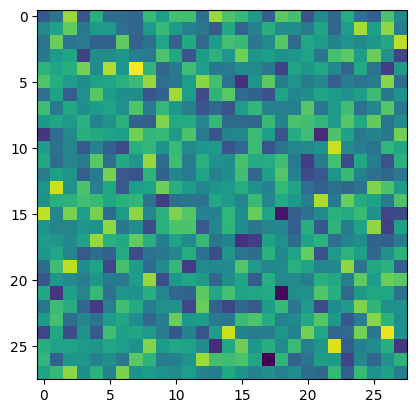

In [11]:
#------TRAINING CODE --------------

def gaussianClassifierWithIdentityCovariance(Xtrain,ytrain):
    
    a = 0.01*np.random.randn(Nfeatures+1,1)
    print("Complete your code")
    
    return a
    #YOUR CODE HERE


#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithIdentityCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)



## Define and test gaussianClassifierWithCommonCovariance 

Complete your code
Mis-classifications= 6318.0 out of  8897 equivalent to 71.01270091041924 %
Mis-classifications= 1034.0 out of  1449 equivalent to 71.35955831608005 %
Mis-classifications= 3135.0 out of  4434 equivalent to 70.70365358592693 %


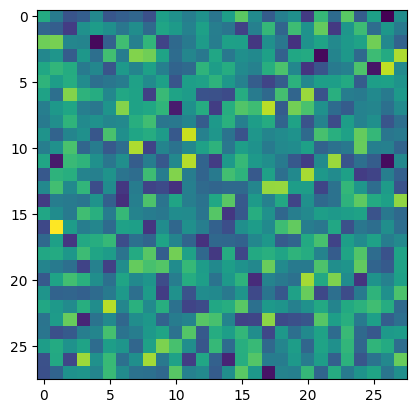

In [12]:
#------TRAINING CODE --------------

def gaussianClassifierWithCommonCovariance(Xtrain,ytrain):

    a = 0.01*np.random.randn(Nfeatures+1,1)
    print("Complete your code")
    
    return a
    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = gaussianClassifierWithCommonCovariance(X_train,y_train)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


## Define and test logisticRegression 

You may choose the step size as 1e-4. You can try changing it.

Use the expit() function from scipy.special.expit to implement sigmoid without overflow errors 

Complete your code
Mis-classifications= 5607.0 out of  8897 equivalent to 63.021243115656965 %
Mis-classifications= 918.0 out of  1449 equivalent to 63.35403726708075 %
Mis-classifications= 2845.0 out of  4434 equivalent to 64.16328371673433 %


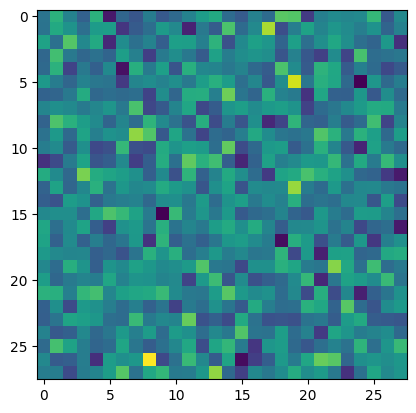

In [13]:
def logisticRegression(Xtrain,ytrain,iterations=100,step_size=1e-4,verbose=False):

    a = 0.01*np.random.randn(Nfeatures+1,1)
    print("Complete your code")
    
    return a
    #YOUR CODE HERE
    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegression(X_train,y_train,iterations=500,verbose=False)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)



Complete your code
Mis-classifications= 4908.0 out of  8897 equivalent to 55.1646622457008 %
Mis-classifications= 779.0 out of  1449 equivalent to 53.76121463077985 %
Mis-classifications= 2467.0 out of  4434 equivalent to 55.638249887235006 %


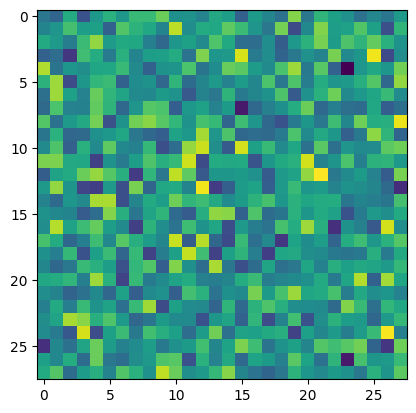

In [14]:
def logisticRegressionWithRegularization(Xtrain,ytrain,iterations=100,step_size=1e-4,lam=0,verbose=False):


    a = 0.01*np.random.randn(Nfeatures+1,1)
    print("Complete your code")
    
    return a
    #YOUR CODE HERE

    
#------SIMPLE TESTING ON THE TRAINING DATA ITSELF --------------
a = logisticRegressionWithRegularization(X_train,y_train,iterations=500,verbose=False,lam=1)
plt.imshow(np.reshape(a[0:784],(28,28)))

train = testLinearClassifier(a,X_train,y_train)
val = testLinearClassifier(a,X_val,y_val)
test = testLinearClassifier(a,X_test,y_test)


In [83]:
def optimizeHyperparameters(Xtrain,ytrain):
     
        # YOUR CODE HERE
        
    return lamopt


# REPORT TEST ERRORS OF THE BEST MODELS

YOUR CODE BELOW